In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import Yukawa_SINDy as ys
import pysindy as ps
from importlib import reload

In [13]:
# included to update Yukawa_SINDy.py version used in this notebook as changes are made
reload(ys)

<module 'Yukawa_SINDy' from '/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py'>

In [14]:
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)

# Code to be moved

In [ ]:
def generate_libraries(t_for_weak):
    # define lambdas for library functions
    library_functions = [
        # lambda x: 1.0, get rid of this term because it is being duplicated and causing an error
        lambda x: x,
        lambda x: np.exp(-x) / x,
        lambda x: np.exp(-x) / x**2,
        lambda x: np.exp(-x) / x**3,
        lambda x: np.exp(-x) / x**4,
    ]

    # define names for library functions
    library_function_names = [
        # lambda x: 1,
        lambda x: x,
        lambda x: "exp(-" + x + ") / " + x,
        lambda x: "exp(-" + x + ") / " + x + "^2",
        lambda x: "exp(-" + x + ") / " + x + "^3",
        lambda x: "exp(-" + x + ") / " + x + "^4",
    ]

    # generate weak form library
    np.random.seed(120398)
    # Note: WSINDy uses a random selection of integration subdomains, so
    # we fix a seed number so we use the same set of subdomains each time
    # this function is called.
    weak_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        spatiotemporal_grid=t_for_weak,
        function_names=library_function_names)

    # generate strong form library
    strong_lib = ps.CustomLibrary(
        library_functions=library_functions, 
        function_names=library_function_names)
    
    return weak_lib, strong_lib

In [ ]:
def scan_thresholds(data, thresholds, verbose=False):
    # data input must be a ys.Yukawa_simulation object or list of these
    # initialize variables
    if isinstance(data, list): 
        multiple_trajectories = True
        x_train = [sim.x for sim in data]
        t_train = data[0].t
    else: 
        multiple_trajectories = False
        x_train = data.x
        t_train = data.t

    weak_lib, strong_lib = generate_libraries(t_train)

    precision = 5
    num_simeq = 3
    complexities = np.empty((2,0))
    fit_weak, fit_strong = 2*(True,)

    # loop through thresholds and fit weak and strong SINDy models to the given dataset
    for thresh in thresholds:
        # set optimizer
        opt = ps.STLSQ(threshold=thresh)
        if verbose:
            print("STLSQ threshold:", thresh)
        # fit weak model
        if fit_weak:
            weak_model = ps.SINDy(feature_names=["x", "v"],
                                feature_library=weak_lib, optimizer=opt)
            weak_model.fit(x_train, multiple_trajectories=multiple_trajectories)
            if verbose:
                print("\nWeak model")
                weak_model.print(precision=precision)
            weak_complexity = weak_model.complexity
        else:
            weak_complexity = -1

        # fit strong model
        if fit_strong:
            strong_model = ps.SINDy(feature_names=["x", "v"],
                                    feature_library=strong_lib, optimizer=opt)
            strong_model.fit(x_train, t=t_train, multiple_trajectories=multiple_trajectories)
            if verbose:
                print("\nStrong model")
                strong_model.print(precision=precision)
                print("\n" + 100*"=" + "\n")
            strong_complexity = strong_model.complexity
        else:
            strong_complexity = -1
        
        # append new complexities to list
        new_complexities = np.array([weak_complexity, strong_complexity]).reshape((2,1))
        complexities = np.append(complexities, new_complexities, axis=1)

        # stop fitting models if complexity is below num_simeq
        if weak_complexity <= num_simeq:
            fit_weak = False
        if strong_complexity <= num_simeq:
            fit_strong = False
        if not fit_weak and not fit_strong:
            break

    # change threshold to have the same dim as complexities
    num_complexities = complexities.shape[1]
    thresholds = thresholds[0:num_complexities]
        
    return thresholds, complexities


In [ ]:
def plot_complexities(thresholds, complexities, noise_level:float):
    fig, ax = plt.subplots(1,1)
    labels = ["Weak model", "Strong model"]
    for i in range (2):
        ax.plot(thresholds, complexities[i], 'o', label=labels[i])
    ax.hlines(3, min(thresholds), max(thresholds),linestyles='dashed', lw=1.5, label="Simulation Equations")
    ax.set_ylim(0, None)
    ax.yaxis.set_major_locator(MultipleLocator(base=2))
    ax.legend()
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Number of terms")
    ax.set_title("Noise level: " + str(np.round(noise_level, 2)))
    fig.tight_layout()
    return fig, ax

In [ ]:
def generate_training_data(n_sims=200, duration=5, dt=0.001, noise_level=0.01):
    # generates list of multiple trajectories with random initial conditions
    # generate init cond
    rng = np.random.default_rng(seed=4862039)
    x0s = rng.normal(1, 0.2, n_sims)
    v0s = rng.choice([-1,1], n_sims) * rng.normal(-0.01, 0.002, n_sims)
    # simulate
    sims = []
    for i in range(n_sims):
        sim = ys.Yukawa_simulation()
        sim.simulate(duration, dt=dt, x0=x0s[i], v0=v0s[i])
        sim.add_gaussian_noise(noise_level=noise_level)
        sims.append(sim)
    
    return sims

# Analysis of Yukawa 2-body data using Weak SINDy

## `std_dev=0.01`

In [32]:
# set var 'noise_level' for this section
noise_level = 0.01

The purpose of this notebook is to use a weak SINDy analysis on 2-body trajectories to see if the sparse recovery of simulation coefficients is improved. Results from the analysis of the same system using only one trajectory with strong-form SINDy (the original formulation) is shown in the notebook 'Yukawa2body.ipynb'.

Here, we will start by using one trajectory of the 2-body equations, as we did before, and then possibly extend to more trajectories.

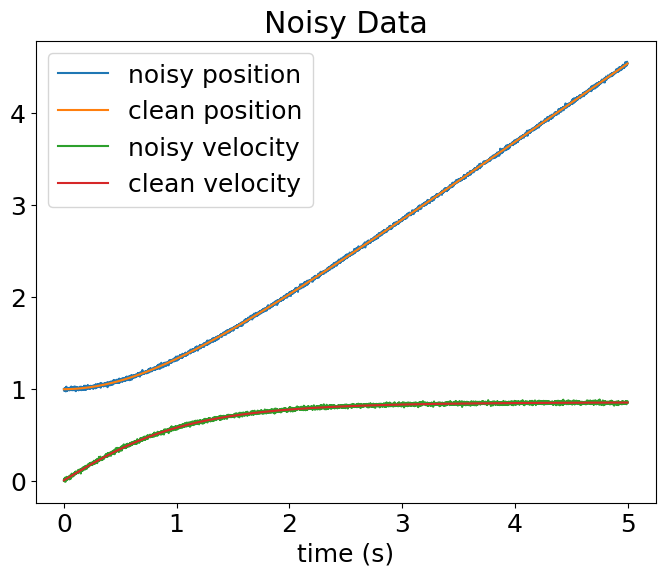

In [33]:
sim001 = ys.Yukawa_simulation()
sim001.simulate(5)
sim001.add_gaussian_noise(noise_level=noise_level)
sim001.plot()

In [36]:
thresholds = np.arange(0, 0.2, 0.01)
thresholds, complexities = scan_thresholds(sim001, thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = 0.01985 x + 0.52106 v + 10.03095 exp(-x) / x + 0.81931 exp(-v) / v + -43.87139 exp(-x) / x^2 + -0.17714 exp(-v) / v^2 + 60.47987 exp(-x) / x^3 + 0.01420 exp(-v) / v^3 + -29.77577 exp(-x) / x^4 + -0.00030 exp(-v) / v^4
(v)' = -0.01941 x + 0.32743 v + -5.68626 exp(-x) / x + -0.52302 exp(-v) / v + 28.41971 exp(-x) / x^2 + 0.12610 exp(-v) / v^2 + -36.01176 exp(-x) / x^3 + -0.01096 exp(-v) / v^3 + 17.00918 exp(-x) / x^4 + 0.00024 exp(-v) / v^4

Strong model
(x)' = 0.11546 x + 0.44409 v + 11.13756 exp(-x) / x + -0.02849 exp(-v) / v + -13.85111 exp(-x) / x^2 + 0.00006 exp(-v) / v^2 + -9.13276 exp(-x) / x^3 + 12.53249 exp(-x) / x^4
(v)' = 0.00655 x + -0.04486 v + 2.31520 exp(-x) / x + -0.00771 exp(-v) / v + -0.78556 exp(-x) / x^2 + 0.00010 exp(-v) / v^2 + -0.68196 exp(-x) / x^3 + 1.30377 exp(-x) / x^4


STLSQ threshold: 0.01

Weak model
(x)' = -0.00471 x + 1.03497 v + -0.13317 exp(-x) / x + -0.03144 exp(-v) / v + 0.00343 exp(-v) / v^2 + 0.41500 exp(-x) /

With this realization of subsets of the integration subdomains, WSINDy discovers the approximately correct model with a threshold of 0.05. The interesting thing is that it does not "converge" to this value, as we continue to increase the threshold the model uses the extraneous term `exp(-v) / v` in its final model.

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

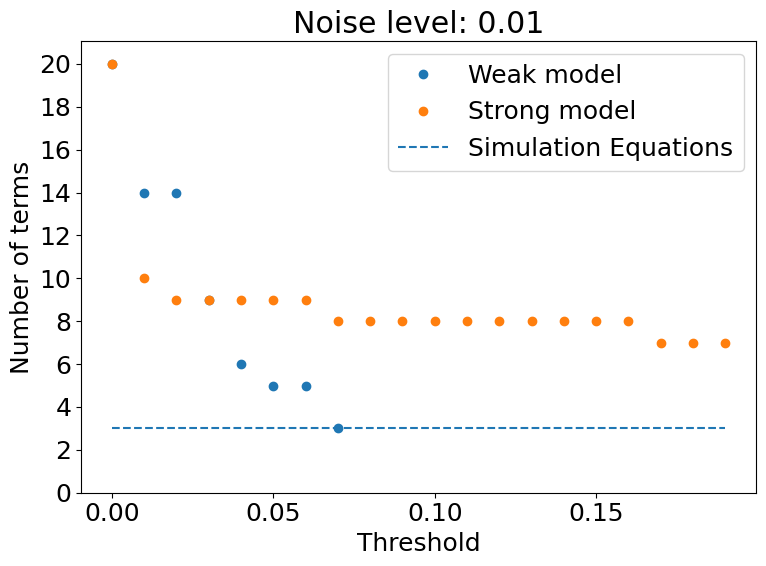

In [38]:
plot_complexities(thresholds, complexities, noise_level=noise_level)

A more complete scan reproduces the result that

STLSQ threshold: 0.0

Weak model
(x)' = 0.01985 x + 0.52106 v + 10.03095 exp(-x) / x + 0.81931 exp(-v) / v + -43.87139 exp(-x) / x^2 + -0.17714 exp(-v) / v^2 + 60.47987 exp(-x) / x^3 + 0.01420 exp(-v) / v^3 + -29.77577 exp(-x) / x^4 + -0.00030 exp(-v) / v^4
(v)' = -0.01941 x + 0.32743 v + -5.68626 exp(-x) / x + -0.52302 exp(-v) / v + 28.41971 exp(-x) / x^2 + 0.12610 exp(-v) / v^2 + -36.01176 exp(-x) / x^3 + -0.01096 exp(-v) / v^3 + 17.00918 exp(-x) / x^4 + 0.00024 exp(-v) / v^4

Strong model
(x)' = 0.11546 x + 0.44409 v + 11.13756 exp(-x) / x + -0.02849 exp(-v) / v + -13.85111 exp(-x) / x^2 + 0.00006 exp(-v) / v^2 + -9.13276 exp(-x) / x^3 + 12.53249 exp(-x) / x^4
(v)' = 0.00655 x + -0.04486 v + 2.31520 exp(-x) / x + -0.00771 exp(-v) / v + -0.78556 exp(-x) / x^2 + 0.00010 exp(-v) / v^2 + -0.68196 exp(-x) / x^3 + 1.30377 exp(-x) / x^4


STLSQ threshold: 0.02

Weak model
(x)' = -0.00471 x + 1.03497 v + -0.13317 exp(-x) / x + -0.03144 exp(-v) / v + 0.00343 exp(-v) / v^2 + 0.41500 exp(-x) /

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

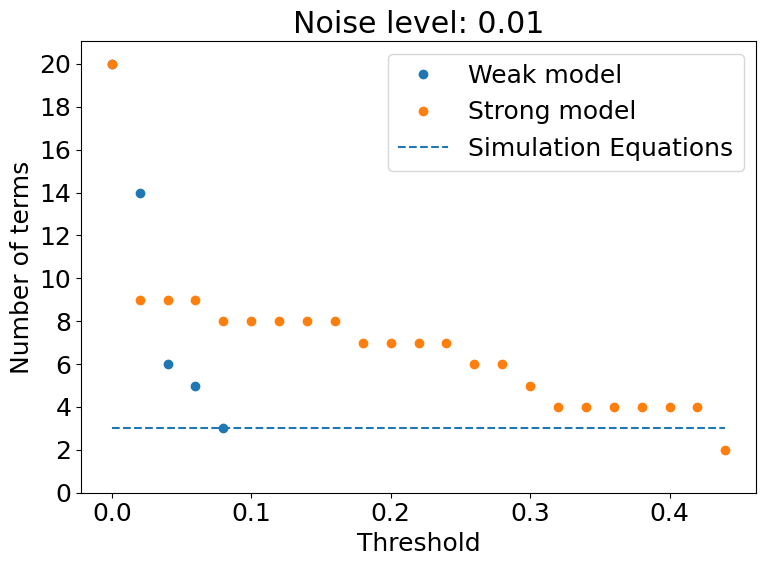

In [39]:
thresholds = np.arange(0, 0.6, 0.02)
thresholds, complexities = scan_thresholds(sim001, thresholds, verbose=True)
plot_complexities(thresholds, complexities, noise_level=noise_level)

From this, we can see that strong form discovers only the correct leading terms, but never actually discovers the correct terms, a result that we also found before.

In [40]:
# code to be used for spot checking whatever threshold
threshold = 0.07
opt = ps.STLSQ(threshold=threshold)
weak_lib, strong_lib = generate_libraries(sim001.t)
weak_model = ps.SINDy(feature_names=["x", "v"], feature_library=weak_lib, optimizer=opt)
weak_model.fit(sim001.x)
weak_model.print(precision=5)

(x)' = 0.99776 v
(v)' = 1.79076 exp(-x) / x + 0.00921 exp(-v) / v


## `std_dev=0.10`

In [41]:
noise_level=0.10

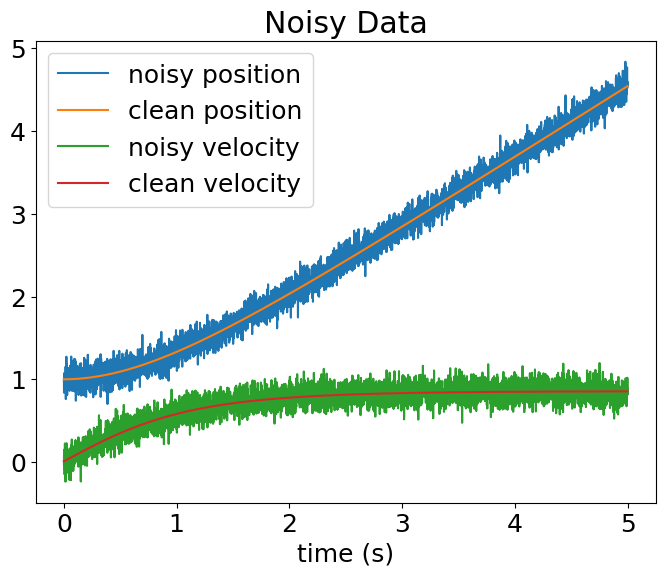

In [42]:
sim010 = ys.Yukawa_simulation()
sim010.simulate(5)
sim010.add_gaussian_noise(noise_level=noise_level)
sim010.plot()

STLSQ threshold: 0.0

Weak model
(x)' = -0.03189 x + 1.21582 v + -0.45395 exp(-x) / x + -0.16818 exp(-v) / v + -0.10624 exp(-x) / x^2 + 0.00095 exp(-v) / v^2 + 0.53069 exp(-x) / x^3 + 1.20800 exp(-x) / x^4
(v)' = -0.05304 x + 0.02906 v + -5.03242 exp(-x) / x + 0.37370 exp(-v) / v + 9.04224 exp(-x) / x^2 + -0.00182 exp(-v) / v^2 + 4.45357 exp(-x) / x^3 + -9.57476 exp(-x) / x^4

Strong model
(x)' = 0.19784 x + 0.05178 v + 0.00376 exp(-x) / x + 0.13858 exp(-v) / v + 0.00275 exp(-x) / x^2 + 0.00004 exp(-v) / v^2 + 0.00223 exp(-x) / x^3 + 0.00195 exp(-x) / x^4
(v)' = 0.06142 x + 0.01603 v + 0.00082 exp(-x) / x + -0.13217 exp(-v) / v + 0.00052 exp(-x) / x^2 + -0.00120 exp(-v) / v^2 + 0.00036 exp(-x) / x^3 + 0.00027 exp(-x) / x^4


STLSQ threshold: 0.02

Weak model
(x)' = -0.01898 x + 1.05719 v + -0.25311 exp(-x) / x + 0.20770 exp(-x) / x^4
(v)' = -0.18393 x + 0.95746 v + -56.05681 exp(-x) / x + -0.00730 exp(-v) / v + 195.96480 exp(-x) / x^2 + -229.68317 exp(-x) / x^3 + 91.23242 exp(-x) / x^4

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.1'}, xlabel='Threshold', ylabel='Number of terms'>)

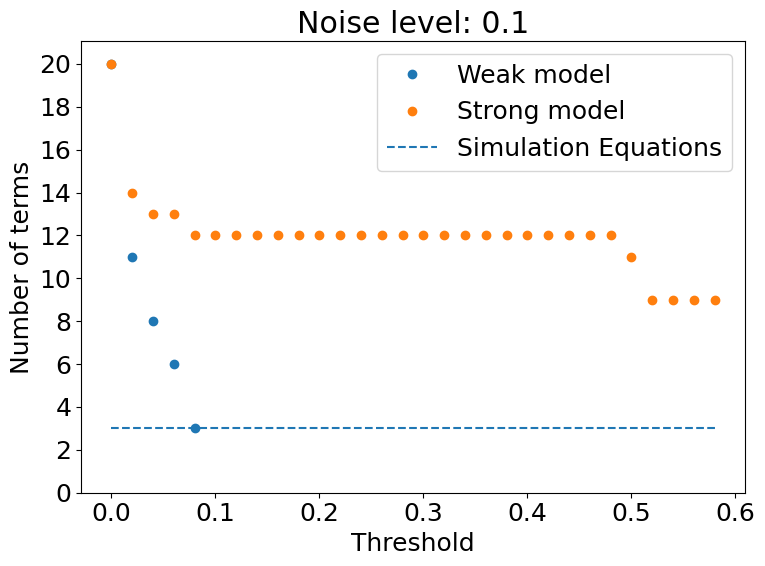

In [43]:
thresholds = np.arange(0, 0.6, 0.02)
thresholds, complexities = scan_thresholds(sim010, thresholds, verbose=True)
plot_complexities(thresholds, complexities, noise_level=noise_level)

With a single trajectory, WSINDy does not recover the correct equations of motion, but it does discover the leading terms along with the presence of extraneous terms. This improves with the multiple trajectories approach.

## Multiple trajectories

We can also generate many trajectories with different initial conditions and use that to train SINDy. This is what we were already doing for the three-body case, but we can see how much it improves the performance of SINDy here.

Note that we generate random initial conditions in the following way:

- *Initial positions*: taken from a normal distribution centered at 1 with std. dev. of 0.2
- *Initial velocities*: taken from a normal distribution centered at 0.01 with a std. dev. of 0.002, also with a random +/- sign.

This was done carefully so as to avoid there being zeros in the initial conditions, which create problems for the solver and for SINDy because of the presence of the rational terms.

### `noise_level=0.01`

In [45]:
# change 'noise_level' back to 0.01
noise_level = 0.01

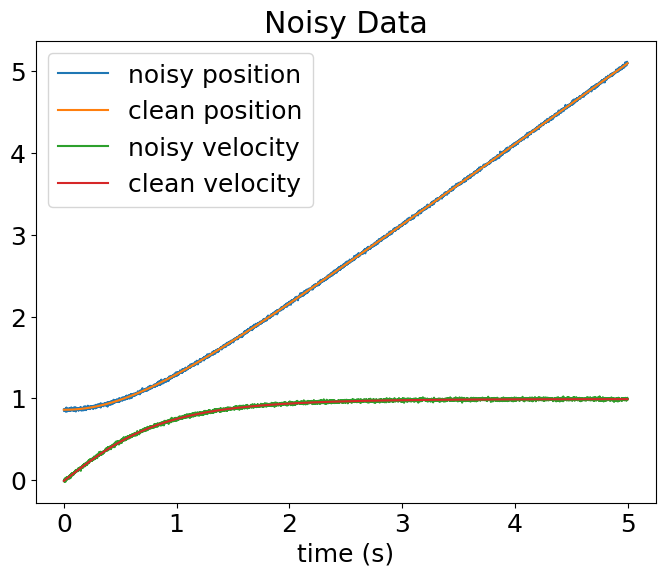

In [46]:
sims001 = generate_training_data(noise_level=noise_level)
sims001[56].plot()

In [47]:
thresholds = np.arange(0, 0.2, 0.01)
thresholds, complexities = scan_thresholds(sims001, thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = -0.00099 x + 1.00162 v + 0.00598 exp(-x) / x + 0.00012 exp(-v) / v + -0.01646 exp(-x) / x^2 + -0.01172 exp(-x) / x^3 + 0.01405 exp(-x) / x^4
(v)' = -0.00137 x + 0.00504 v + 1.03943 exp(-x) / x + 0.00077 exp(-v) / v + 0.72792 exp(-x) / x^2 + 0.35262 exp(-x) / x^3 + -0.12902 exp(-x) / x^4

Strong model
(x)' = -0.00640 x + 1.02325 v + -0.01922 exp(-x) / x + 0.00001 exp(-v) / v + -0.03551 exp(-x) / x^2 + -0.02780 exp(-x) / x^3 + 0.00401 exp(-x) / x^4
(v)' = -0.00083 x + -0.00734 v + 1.07317 exp(-x) / x + 0.77447 exp(-x) / x^2 + 0.39357 exp(-x) / x^3 + -0.16617 exp(-x) / x^4


STLSQ threshold: 0.01

Weak model
(x)' = 0.99793 v
(v)' = 1.09565 exp(-x) / x + 0.71489 exp(-x) / x^2 + 0.25088 exp(-x) / x^3 + -0.06700 exp(-x) / x^4

Strong model
(x)' = 0.99788 v + 0.33524 exp(-x) / x + -0.87164 exp(-x) / x^2 + 0.61281 exp(-x) / x^3 + -0.15324 exp(-x) / x^4
(v)' = -0.01717 v + 2.22068 exp(-x) / x + -2.27379 exp(-x) / x^2 + 2.96908 exp(-x) / x^3 + -0.85639 exp

### `noise_level=0.10`

In [48]:
noise_level = 0.10

In [49]:
sims010 = generate_training_data(noise_level=noise_level)

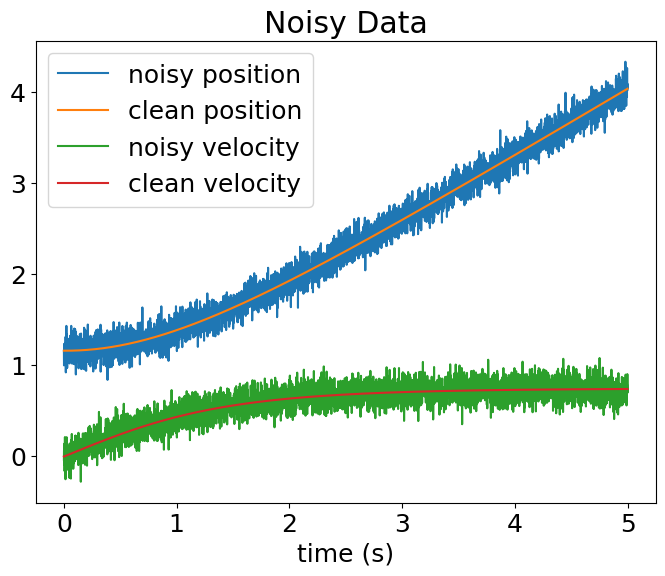

In [50]:
sims010[38].plot()

In [51]:
# thresholds = np.arange(0, 0.2, 0.01)
thresholds = np.concatenate((np.arange(0, 0.2, 0.01), np.arange(0.2, 1.0, 0.05), np.arange(1.0, 5.0, 0.5)))
libs = generate_libraries(sims010[0].t)
x_train010 = [sim.x for sim in sims010]
t_train010 = sims010[0].t
thresholds, complexities = scan_thresholds(sims010, thresholds)

/opt/anaconda3/envs/yukawa-sindy-vetted/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (2.0) and eliminated all coefficients
  warnings.warn(


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.1'}, xlabel='Threshold', ylabel='Number of terms'>)

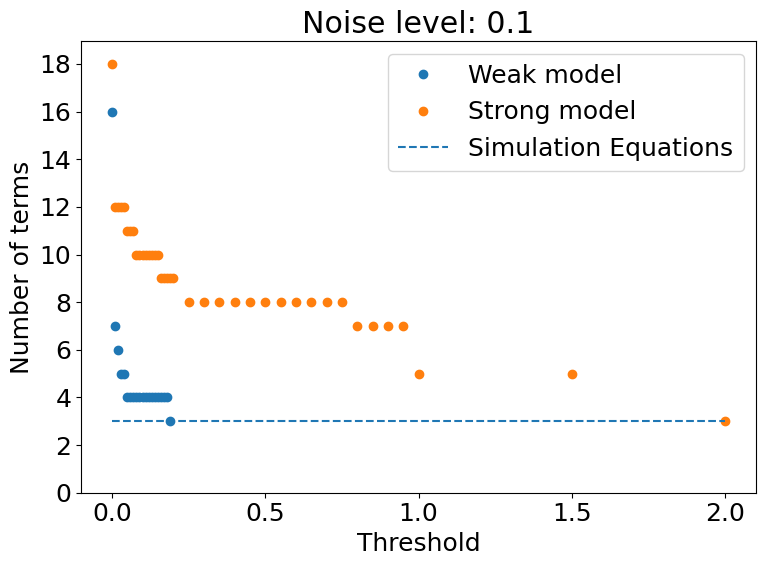

In [53]:
plot_complexities(thresholds, complexities, noise_level=noise_level)

Noticing as these models are coming out that there is a long series of the exact same models between 0.05 and 0.18 in the weak case, with a few steps happening for the strong models. 
It might be interesting to look into an optimal threshold step size that would minimize SINDy discovering the same model over and over again.

In [ ]:
x_train = [sim.x for sim in sims010] # if sim.x.shape[0] == 5000]
t_train = sims010[0].t
weak_lib, strong_lib = generate_libraries(t_train)
opt = ps.STLSQ(threshold=0.5)
strong_model = ps.SINDy(feature_names=["x", "v"],feature_library=strong_lib, optimizer=opt)
strong_model.fit(x_train, t=t_train, multiple_trajectories=True)
strong_model.print(precision=5)

(x)' = 25.02832 exp(-x) / x + -46.32102 exp(-x) / x^2 + 26.70239 exp(-x) / x^3 + -4.86520 exp(-x) / x^4
(v)' = 3.78581 exp(-x) / x + -4.06016 exp(-x) / x^2 + 3.09421 exp(-x) / x^3 + -0.98733 exp(-x) / x^4


In [ ]:
opt = ps.STLSQ(threshold=0.2)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)

(x)' = 0.97920 v
(v)' = 1.02562 exp(-x) / x + 0.86036 exp(-x) / x^2


The weak form of SINDy discovers the correct underlying model with a threshold of 0.2, while strong-form SINDy does not discover the correct model.

### `noise_level=0.20`

In [56]:
noise_level=0.20

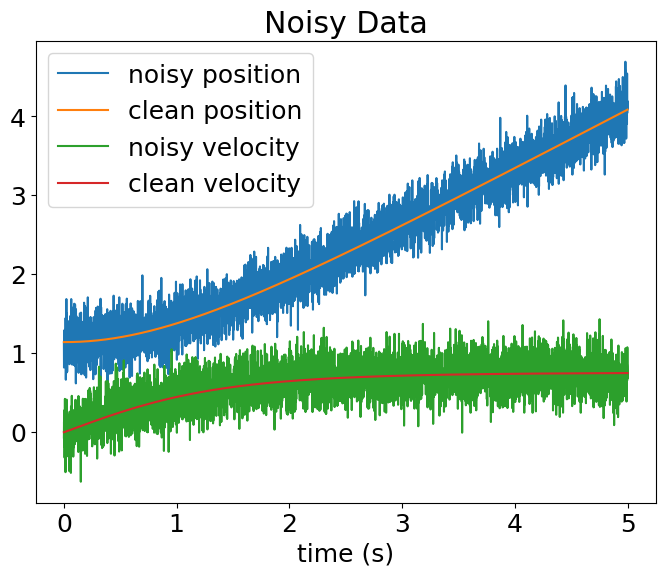

In [57]:
sims020 = generate_training_data(noise_level=noise_level)
sims020[42].plot()

In [66]:
thresholds = np.concatenate((np.arange(0,0.001,1e-4), np.arange(0, 0.01, 0.001), np.arange(0.01,0.2,0.05)))
thresholds, complexities = scan_thresholds(sims020, thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = 0.00000
(v)' = 0.00000

Strong model
(x)' = 0.00000
(v)' = 0.00000


STLSQ threshold: 0.0001

Weak model
(x)' = -0.01686 x + 1.02362 v + -0.10354 exp(-x) / x + 0.00246 exp(-x) / x^2
(v)' = -0.00990 x + 0.02401 v + 1.52581 exp(-x) / x + 0.12655 exp(-x) / x^2 + -0.00042 exp(-x) / x^3

Strong model
(x)' = 0.76326 x + -2.09070 v + 0.87450 exp(-x) / x + -0.08133 exp(-x) / x^2 + 0.00025 exp(-x) / x^3
(v)' = 0.14838 x + -0.35008 v + -3.42541 exp(-x) / x + 0.00029 exp(-v) / v + 2.19912 exp(-x) / x^2 + -0.06258 exp(-x) / x^3 + 0.00017 exp(-x) / x^4


STLSQ threshold: 0.0002

Weak model
(x)' = -0.01686 x + 1.02362 v + -0.10354 exp(-x) / x + 0.00246 exp(-x) / x^2
(v)' = -0.00990 x + 0.02401 v + 1.52581 exp(-x) / x + 0.12655 exp(-x) / x^2 + -0.00042 exp(-x) / x^3

Strong model
(x)' = 0.76326 x + -2.09070 v + 0.87450 exp(-x) / x + -0.08133 exp(-x) / x^2 + 0.00025 exp(-x) / x^3
(v)' = 0.16644 x + -0.54038 v + -0.25630 exp(-x) / x + 0.00029 exp(-v) / v + 0.4709

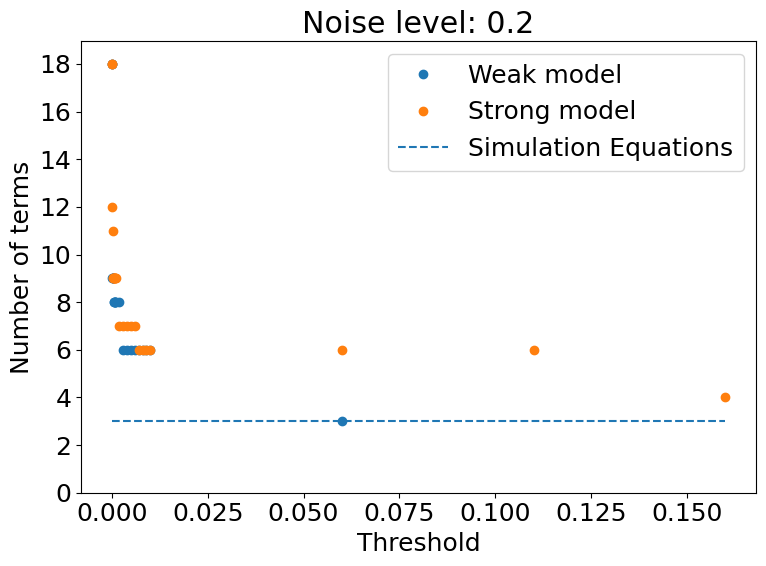

In [67]:
fig, ax = plot_complexities(thresholds, complexities, noise_level=noise_level)

(-0.0002, 0.0102)

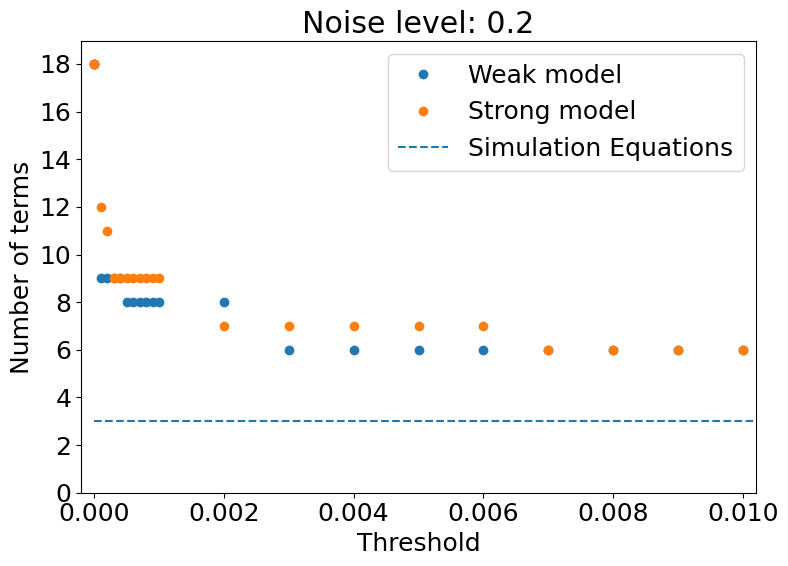

In [68]:
fig, ax = plot_complexities(thresholds, complexities, noise_level=noise_level)
pad = 2e-4
ax.set_xlim(0-pad, 0.01+pad)

### `noise_level=0.50`

In [71]:
noise_level=0.50

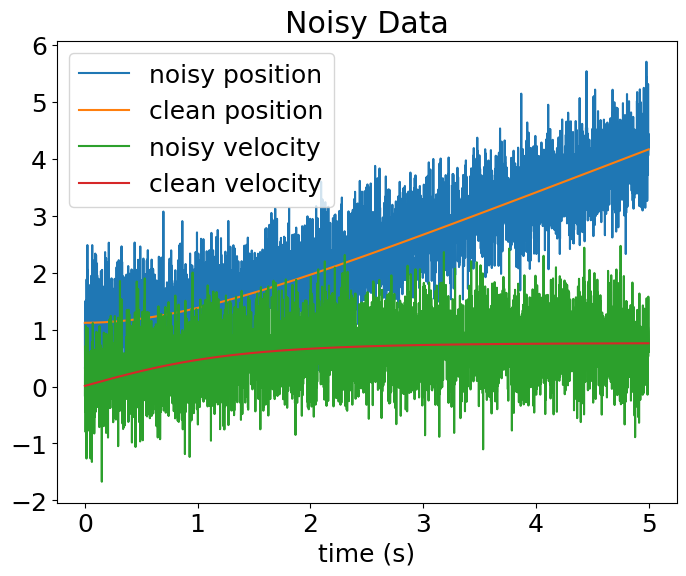

In [72]:
sims050 = generate_training_data(noise_level=noise_level)
sims050[0].plot()

In [73]:
thresholds = np.arange(0, 0.5, 0.05)
thresholds, complexities = scan_thresholds(sims050, thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = 0.22693 x + 0.06244 v + 0.00658 exp(-x) / x + 0.00006 exp(-v) / v + 0.00001 exp(-x) / x^2
(v)' = 0.02140 x + 0.00589 v + 0.00062 exp(-x) / x + 0.00013 exp(-v) / v + 0.00002 exp(-x) / x^2

Strong model
(x)' = 0.00000
(v)' = 0.14394 x + 0.03808 v + -0.02191 exp(-x) / x + 0.00020 exp(-v) / v


STLSQ threshold: 0.05

Weak model
(x)' = 0.89371 v
(v)' = -0.12263 x + 0.53171 v

Strong model
(x)' = 1.50101 x + -5.15070 v
(v)' = 0.50596 x + -1.33182 v


STLSQ threshold: 0.1

Strong model
(x)' = 1.50101 x + -5.15070 v
(v)' = 0.50596 x + -1.33182 v


STLSQ threshold: 0.15000000000000002

Strong model
(x)' = 1.50101 x + -5.15070 v
(v)' = 0.50596 x + -1.33182 v


STLSQ threshold: 0.2

Strong model
(x)' = 1.50101 x + -5.15070 v
(v)' = 0.50596 x + -1.33182 v


STLSQ threshold: 0.25

Strong model
(x)' = 1.50101 x + -5.15070 v
(v)' = 0.50596 x + -1.33182 v


STLSQ threshold: 0.30000000000000004

Strong model
(x)' = 1.50101 x + -5.15070 v
(v)' = 0.50596 x + -1.331

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.5'}, xlabel='Threshold', ylabel='Number of terms'>)

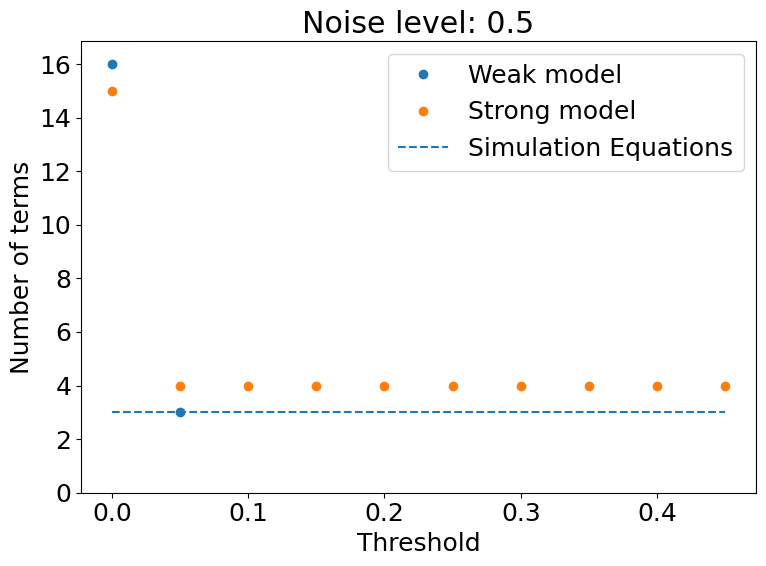

In [74]:
plot_complexities(thresholds, complexities, noise_level=noise_level)

In [75]:
# code for spot-checking weak models
x_train = [sim.x for sim in sims050]
t_train = sims050[0].t

weak_lib, strong_lib = generate_libraries(t_train)
opt = ps.STLSQ(threshold=0.0001)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(x_train, t=t_train, multiple_trajectories=True)
weak_model.print(precision=5)

(x)' = -0.02101 x + 0.96480 v + -0.00905 exp(-x) / x
(v)' = -0.11985 x + 0.51912 v + 0.02715 exp(-x) / x + 0.00011 exp(-v) / v


In [76]:
print(weak_model.coefficients().T)

[[-2.10100727e-02 -1.19852118e-01]
 [ 9.64798968e-01  5.19118866e-01]
 [-9.04547255e-03  2.71548353e-02]
 [ 0.00000000e+00  1.11426902e-04]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]]


In [77]:
weak_model.complexity

7